<a href="https://colab.research.google.com/github/TalCordova/PyTorch_Practice/blob/main/Stock_Price_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction with PyTorch 🐍🔥🔥

In [212]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch

In [213]:
import matplotlib.dates as mdates
def plot_data(df):

  df_plot = df.copy()
  ncols = 2
  nrows = int(round(df_plot.shape[1] / ncols, 0))

  fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, figsize = (20, 10))
  for i, ax in enumerate(fig.axes):
    sns.lineplot(data = df_plot.iloc[:, i], ax = ax)
    ax.tick_params(axis = "x", rotation = 30, labelsize = 10, length = 0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
  fig.tight_layout()
  plt.show()

In [214]:
import yfinance as yf
ticker = yf.Ticker("AAPL")
ticker.info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '(408) 996-1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and p

In [215]:
df = yf.download(['AAPL'], period = "5y")

[*********************100%***********************]  1 of 1 completed


In [216]:
df.head(), df.shape

(Price       Adj Close      Close       High        Low       Open     Volume
 Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
 Date                                                                        
 2019-12-09  64.693581  66.730003  67.699997  66.227501  67.500000  128042400
 2019-12-10  65.071671  67.120003  67.517502  66.464996  67.150002   90420400
 2019-12-11  65.626686  67.692497  67.775002  67.125000  67.202499   78756800
 2019-12-12  65.793938  67.864998  68.139999  66.830002  66.945000  137310400
 2019-12-13  66.688263  68.787498  68.824997  67.732498  67.864998  133587600,
 (1258, 6))

In [217]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2019-12-09,64.693581,66.730003,67.699997,66.227501,67.500000,128042400
2019-12-10,65.071671,67.120003,67.517502,66.464996,67.150002,90420400
2019-12-11,65.626686,67.692497,67.775002,67.125000,67.202499,78756800
2019-12-12,65.793938,67.864998,68.139999,66.830002,66.945000,137310400
2019-12-13,66.688263,68.787498,68.824997,67.732498,67.864998,133587600


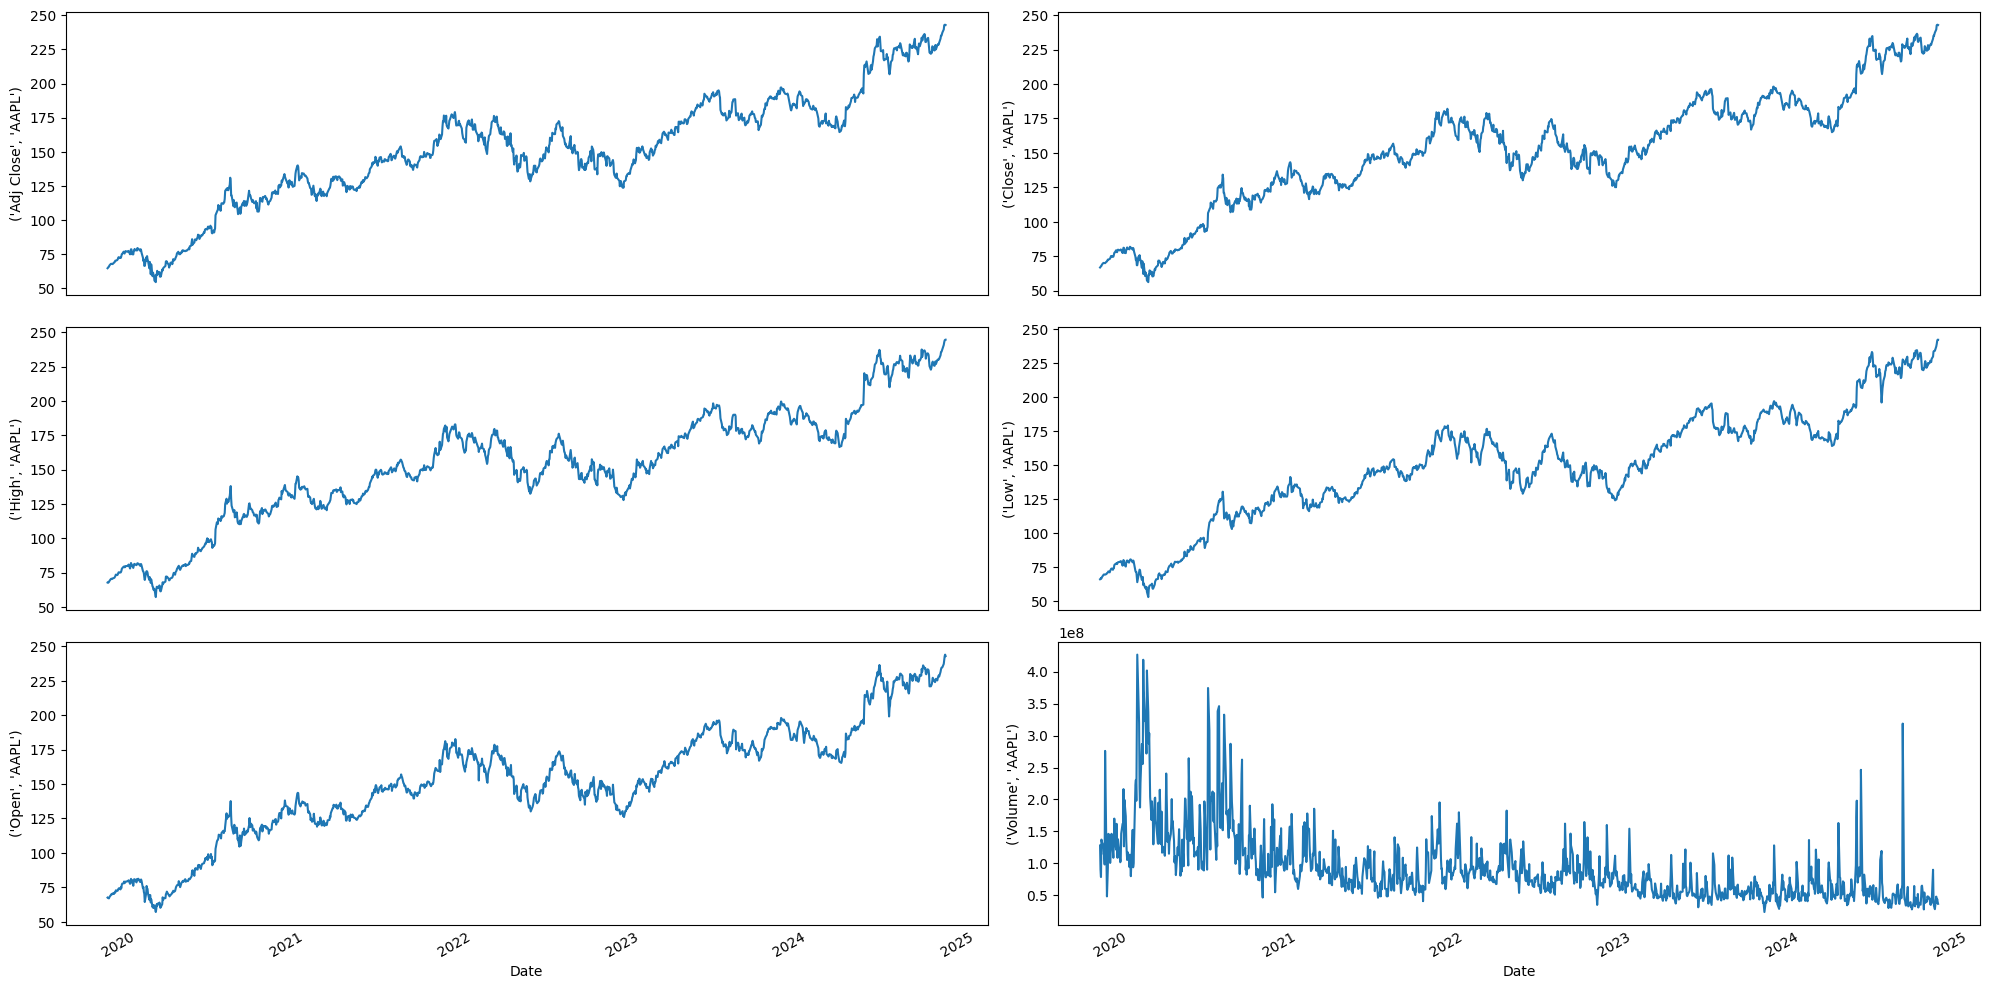

In [218]:
plot_data(df)

## Create Custom Data Class

In this case, we are not downloading the data straight from PyTorch - we are recieving it as a dataframe, and we need to turn it to to type `Dataset` - this way, we can can turn it to  a `DataLoader`.

We will create a class `StockDataset` the inherits from `Dataset`. It will recieive a `pd.dataframe` as argument and sequence length.

The length of the dataset is the number of sequences.

An item is made of a list length `sequence_length`, and the target - which is the next instance after the sequence.

In [219]:
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

class StockDataset(Dataset):
  def __init__(self, df, sequence_length):
    self.scaler = MinMaxScaler()
    df['Close'] = self.scaler.fit_transform(df[['Close']])
    df['Volume'] = MinMaxScaler().fit_transform(df[['Volume']])
    self.df = df
    self.sequence_length = sequence_length

    self.df['DayOfWeek'] = pd.to_datetime(df.index).dayofweek
    self.df['Month'] = pd.to_datetime(df.index).month

    self.features = [
            'Close',
            'Volume',
            'DayOfWeek',
            'Month'
    ]

  def __len__(self):
    return len(self.df) - self.sequence_length

  def __getitem__(self, idx):
      # Convert to numpy arrays first
      sequence = self.df[self.features].iloc[idx:idx + self.sequence_length].to_numpy()
      target = self.df['Close'].iloc[idx + self.sequence_length].to_numpy()

      # Convert numpy arrays to tensors
      sequence = torch.FloatTensor(sequence)
      target = torch.FloatTensor(target).reshape(-1)

      return sequence, target

## Create Data Set and Put it in `DataLoader`

In [220]:
dataset = StockDataset(df, sequence_length = 30)

In [221]:
train_size = int(0.8 * len(dataset))

train_dataset = torch.utils.data.Subset(dataset, range(train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

In [222]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [223]:
sequence, target = train_dataset[0]  # First sequence
print("First sequence shape:", sequence.shape)
print("Sequence data:", sequence)
print("Target:", target)

# Look at another sequence
sequence, target = train_dataset[5]  # Sixth sequence
print("\nSixth sequence shape:", sequence.shape)
print("Sequence data:", sequence)
print("Target:", target)

First sequence shape: torch.Size([30, 4])
Sequence data: tensor([[ 0.0569,  0.2584,  0.0000, 12.0000],
        [ 0.0590,  0.1649,  1.0000, 12.0000],
        [ 0.0620,  0.1359,  2.0000, 12.0000],
        [ 0.0630,  0.2814,  3.0000, 12.0000],
        [ 0.0679,  0.2722,  4.0000, 12.0000],
        [ 0.0742,  0.2588,  0.0000, 12.0000],
        [ 0.0749,  0.2239,  1.0000, 12.0000],
        [ 0.0740,  0.2285,  2.0000, 12.0000],
        [ 0.0744,  0.1847,  3.0000, 12.0000],
        [ 0.0736,  0.6260,  4.0000, 12.0000],
        [ 0.0797,  0.1852,  0.0000, 12.0000],
        [ 0.0801,  0.0607,  1.0000, 12.0000],
        [ 0.0876,  0.1716,  3.0000, 12.0000],
        [ 0.0875,  0.3037,  4.0000, 12.0000],
        [ 0.0898,  0.2983,  0.0000, 12.0000],
        [ 0.0926,  0.1907,  1.0000, 12.0000],
        [ 0.1016,  0.2769,  3.0000,  1.0000],
        [ 0.0977,  0.3038,  4.0000,  1.0000],
        [ 0.1009,  0.2344,  0.0000,  1.0000],
        [ 0.0990,  0.2108,  1.0000,  1.0000],
        [ 0.1054,  0.26

## Build The Model

In [224]:
import torch.nn as nn
class LSTMStockPredictor(nn.Module):
  def __init__(self,
               input_size: int,
               hidden_size: int):
    super().__init__()
    self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        batch_first = True)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    # print(f"Input shape: {x.shape}")  # Should be [batch_size, sequence_length, features]

    lstm_out, (h_n, c_n) = self.lstm(x)  # Now unpacking both hidden states
    # print(f"LSTM output shape: {lstm_out.shape}")  # [batch_size, sequence_length, hidden_size]

    last_hidden = lstm_out[:, -1, :]
    # print(f"Last hidden state shape: {last_hidden.shape}")  # [batch_size, hidden_size]

    predictions = self.linear(last_hidden)
    # print(f"Predictions shape: {predictions.shape}")  # [batch_size, 1]

    return predictions

## Train the Model

In [225]:
def mse_fn(y_true, y_pred):
    """Calculates MSE between truth values and predictions.

    Args:
        y_true (torch.Tensor): True stock prices.
        y_pred (torch.Tensor): Predicted stock prices.

    Returns:
        [torch.float]: MSE value between y_true and y_pred
    """
    mse = nn.MSELoss()(y_pred, y_true)
    return mse.item()

In [226]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """
  Prints difference between start and endt time.
  """
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [227]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [228]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  """
  Performs a training with model trying to learn on data_loader
  """
  train_loss = 0
  model.train()

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    # 3. Optimzier zero grad
    optimizer.zero_grad()
    # 4. Loss backwards
    loss.backward()
    #5. Optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  print(f"Train loss: {train_loss:.5f}")

In [229]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
  """
  Performs a testing loop step on model going over data_loader
  """

  ### Testing
  test_loss = 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculate the loss/acc (accumutively)
      test_loss += loss_fn(test_pred, y)

    # Adjust metrics and print out
    test_loss /= len(test_dataloader)
    print(f"Test loss {test_loss:.5f}")

In [230]:
model = LSTMStockPredictor(4, 64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [231]:
torch.manual_seed(42)

# Measure the time
import tqdm.auto as tqdm
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Measure the time
train_time_start_on_gpu = timer()

epochs = 10

for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-----")
  train_step(model = model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer)
  test_step(model = model,
            data_loader = test_dataloader,
            loss_fn = loss_fn)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                            end = train_time_end_on_gpu,
                                            device = device)

Epoch: 0
-----
Train loss: 0.02416
Test loss 0.07229
Epoch: 1
-----
Train loss: 0.04178
Test loss 0.04814
Epoch: 2
-----
Train loss: 0.04764
Test loss 0.07890
Epoch: 3
-----
Train loss: 0.03345
Test loss 0.06936
Epoch: 4
-----
Train loss: 0.03261
Test loss 0.06513
Epoch: 5
-----
Train loss: 0.03070
Test loss 0.05964
Epoch: 6
-----
Train loss: 0.02882
Test loss 0.05248
Epoch: 7
-----
Train loss: 0.02697
Test loss 0.04355
Epoch: 8
-----
Train loss: 0.02496
Test loss 0.03282
Epoch: 9
-----
Train loss: 0.02267
Test loss 0.02222
Train time on cuda: 17.099 seconds


In [239]:
torch.manual_seed(42)
from tqdm.auto import tqdm
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               scaler,
               device = device):
  """
  Returns a dictionary contaning the results of model predicting on data_loader
  """
  model.eval()
  loss = 0
  predictions = []
  actuals = []
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make data device agnostic
      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      predictions.extend(y_pred.cpu().numpy())
      actuals.extend(y.cpu().numpy())

    # Scale the loss and acc to find the average loss\acc per batch
    loss /= len(data_loader)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "predictions": predictions,
        "actuals": actuals
    }

In [240]:
# Get model_1 results dictionary
lstm_results = eval_model(model = model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             device = device,
                            scaler = dataset.scaler)
lstm_results

  0%|          | 0/8 [00:00<?, ?it/s]

{'model_name': 'LSTMStockPredictor',
 'model_loss': 0.02221723273396492,
 'predictions': array([[179.27058],
        [179.31845],
        [179.31184],
        [178.11743],
        [178.08778],
        [179.61311],
        [181.71672],
        [181.74821],
        [180.2855 ],
        [181.22034],
        [182.35812],
        [180.2835 ],
        [176.78172],
        [176.50371],
        [180.16731],
        [180.99925],
        [179.88618],
        [181.69827],
        [185.39641],
        [190.19829],
        [191.81187],
        [191.88313],
        [193.13942],
        [196.01123],
        [196.54645],
        [194.6085 ],
        [194.37209],
        [196.04561],
        [198.63814],
        [198.4746 ],
        [194.56374],
        [193.04007],
        [194.72319],
        [195.18222],
        [194.75116],
        [192.06956],
        [191.43266],
        [193.1727 ],
        [195.64607],
        [194.98189],
        [190.61208],
        [189.4337 ],
        [190.22722],
        [

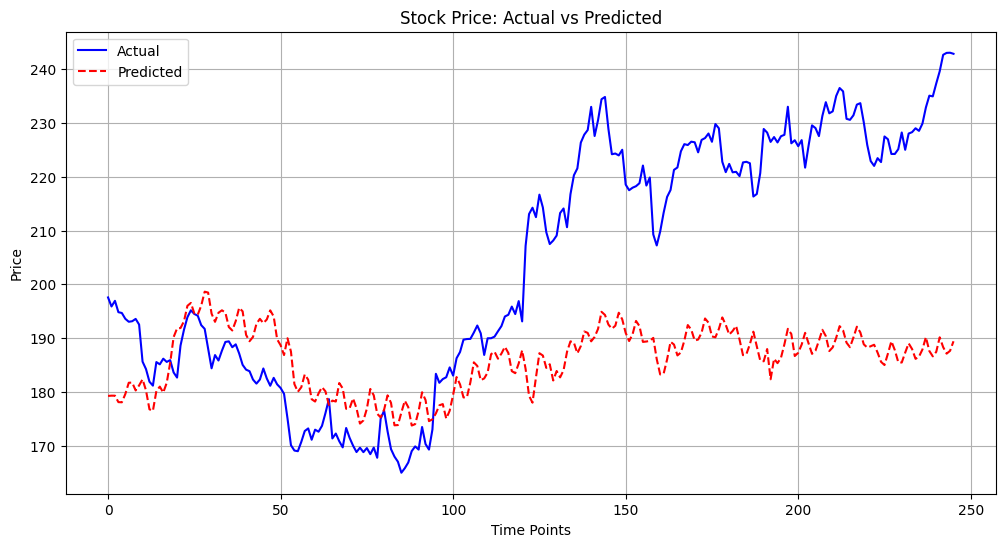

In [241]:
time_points = range(len(lstm_results["predictions"]))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_points, lstm_results["actuals"], label='Actual', color='blue')
plt.plot(time_points, lstm_results["predictions"], label='Predicted', color='red', linestyle='--')
plt.title('Stock Price: Actual vs Predicted')
plt.xlabel('Time Points')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()